In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding,Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import Counter
import logging
import time
import pickle
import itertools

In [2]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
df = pd.read_csv("sentiment_tweets3.csv")

In [63]:
df.tail(10)

,Index,message to examine,label (depression result)
10304,802304,"Reagan, Bush 43 & Trump, all GOP, all used MAG...",1
10305,802305,RT Depression Could Be Improved With Vitamin D...,1
10306,802306,actors symptoms of adult depression naked gtee...,1
10307,802307,@GaindaSwamy @Kanatungaa @Being_Humor @theskin...,1
10308,802308,Many sufferers of depression aren't sad; they ...,1
10309,802309,No Depression by G Herbo is my mood from now o...,1
10310,802310,What do you do when depression succumbs the br...,1
10311,802311,Ketamine Nasal Spray Shows Promise Against Dep...,1
10312,802312,dont mistake a bad day with depression! everyo...,1
10313,802313,0,1


In [6]:
df.columns

Index(['Index', 'message to examine', 'label (depression result)'], dtype='object')

In [7]:
df1 = pd.DataFrame({"Text":df["message to examine"],"Target":df["label (depression result)"]})

In [8]:
#Parameters
TRAIN_SIZE = 0.7
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"

SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

## Observation 
* There is class imbalance as the number of negative samples is greater than the positive samples.
* Model may not not give that good accuracy.
* Solution is undersampling or oversampling 

Text(0.5, 1.0, 'Number of samples present in each class')

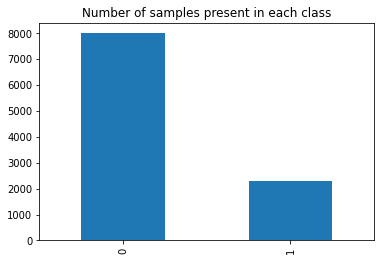

In [9]:
df1.Target.value_counts().plot(kind="bar")
plt.title("Number of samples present in each class")

In [10]:
#Mapping the target to labels 
turn_map = {0:"NEGATIVE",1:"POSITIVE"}
def map(label):
  return turn_map[int(label)]

In [11]:
df1.Target = df1.Target.apply(lambda x:map(x))

In [12]:
df1.head()

,Text,Target
0,just had a real good moment. i missssssssss hi...,NEGATIVE
1,is reading manga http://plurk.com/p/mzp1e,NEGATIVE
2,@comeagainjen http://twitpic.com/2y2lx - http:...,NEGATIVE
3,@lapcat Need to send 'em to my accountant tomo...,NEGATIVE
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,NEGATIVE


## Pre process the dataset 
* Remove unwantedtext - urls, email ids, etc
* Remove Stopwords
* Convert to lowercase

In [13]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [14]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = str(text).lower()
    text = re.sub(TEXT_CLEANING_RE, ' ', text).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [15]:
df1.Text = df1.Text.apply(lambda x: preprocess(x))

In [16]:
df_train, df_test = train_test_split(df1, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 7219
TEST size: 3095


In [17]:
documents = [_text.split() for _text in df_train.Text] 

In [18]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [19]:
w2v_model.build_vocab(documents)

In [20]:
w2v_model.most_similar("luv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('anyone', 0.18737627565860748),
 ('yup', 0.17788122594356537),
 ('help', 0.16258974373340607),
 ('k', 0.1607014238834381),
 ('human', 0.15029513835906982),
 ('picture', 0.14823950827121735),
 ('sweet', 0.14806243777275085),
 ('positive', 0.14343252778053284),
 ('p', 0.13292032480239868),
 ('healing', 0.12982285022735596)]

In [21]:
len(documents)

7219

### Tokenize your text




In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.Text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 13258


In [23]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.Text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.Text), maxlen=SEQUENCE_LENGTH)

### Label encode the target column 

In [24]:
labels = df_train.Target.unique().tolist()

labels

['NEGATIVE', 'POSITIVE']

In [25]:
encoder = LabelEncoder()
encoder.fit(df_train.Target.tolist())

y_train = encoder.transform(df_train.Target.tolist())
y_test = encoder.transform(df_test.Target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (7219, 1)
y_test (3095, 1)


In [26]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (7219, 300)
y_train (7219, 1)

x_test (3095, 300)
y_test (3095, 1)


In [27]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(13258, 300)


In [28]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0004201 ,  0.00088702, -0.00159205, ..., -0.00120886,
         0.00080144,  0.00033326],
       [-0.00031919,  0.00026593, -0.0002791 , ...,  0.0013682 ,
        -0.0005392 ,  0.00148115],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [29]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Building the model

In [50]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          3977400   
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 4,137,901
Trainable params: 160,501
Non-trainable params: 3,977,400
_________________________________________________________________


In [51]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [52]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [74]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=20,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/20
7/7 [==============================] - 10s 1s/step - loss: 0.5345 - accuracy: 0.7710 - val_loss: 0.5153 - val_accuracy: 0.7867
Epoch 2/20
7/7 [==============================] - 10s 1s/step - loss: 0.5339 - accuracy: 0.7710 - val_loss: 0.5136 - val_accuracy: 0.7867
Epoch 3/20
7/7 [==============================] - 9s 1s/step - loss: 0.5338 - accuracy: 0.7710 - val_loss: 0.5128 - val_accuracy: 0.7867
Epoch 4/20
7/7 [==============================] - 10s 1s/step - loss: 0.5324 - accuracy: 0.7710 - val_loss: 0.5131 - val_accuracy: 0.7867
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: 0.5316 - accuracy: 0.7710 - val_loss: 0.5106 - val_accuracy: 0.7867
Epoch 6/20
7/7 [==============================] - 9s 1s/step - loss: 0.5307 - accuracy: 0.7710 - val_loss: 0.5107 - val_accuracy: 0.7867


In [75]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

4/4 [==============================] - 1s 140ms/step - loss: 0.5152 - accuracy: 0.7829

ACCURACY: 0.7828755974769592
LOSS: 0.5152456760406494


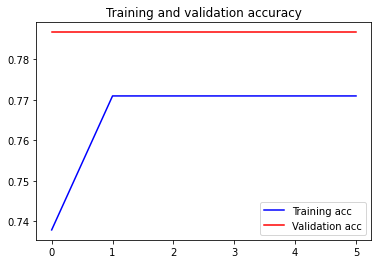

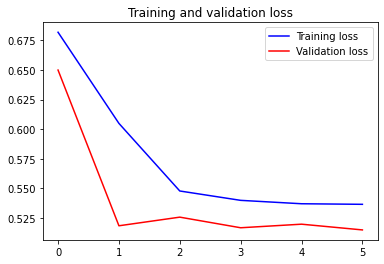

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [56]:
def decode_sentiment(score):
    return NEGATIVE if score < 0.5 else POSITIVE

In [68]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    text = preprocess(text=text)
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [69]:
predict("I love the music")

{'elapsed_time': 0.13775897026062012,
 'label': 'NEGATIVE',
 'score': 0.21587786078453064}

### Observations 


*   Bad accuracy because of class imbalance 
*   Reduce the number of negative samples (Under sampling)

